# Review Classification

## Batching and Model Training

### Import Libraries

In [1]:
import pandas as pd # Loading data
import numpy as np
import warnings
from sklearn.model_selection import train_test_split # train test splits

warnings.filterwarnings('ignore')

### Data Loading and Processing

We will first do all the necessary pre-processing before starting to create batches and training the model. All the steps are explained in the notebook named `Text Cleaning.ipynb`

In [2]:
# Read dataset
data = pd.read_csv("Reviews.csv")
# Drop unnecesary columns and duplicates
new_data = data.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'])
# Get useful columns
useful_data = new_data[['Text', 'Score']]
# Calculate length of each sentence without tokenizer
useful_data['sudo_length'] = useful_data.Text.str.split().str.len()
# Filter examples by length
useful_data = useful_data[(useful_data.sudo_length > 20) & (useful_data.sudo_length < 100)]
# Remove length column
useful_data = useful_data.drop(['sudo_length'], axis = 1)
# print 5 rows
useful_data.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


#### Create Train and Test sets

In [3]:
train, test = train_test_split(useful_data, test_size = 0.2)
train.to_csv("./train_test_data/train.csv", index=False)
test.to_csv("./train_test_data/test.csv", index=False)

In [4]:
import torchtext
from torchtext.data import TabularDataset, Field, BucketIterator
import spacy

In [5]:
tok = spacy.load('en_core_web_sm')

In [6]:
def tokenize_en(sent):
    sent = sent.lower()
    return [item.text for item in tok.tokenizer(sent)]

In [7]:
sent = "hello their, why don't u have a seat?"
tokenize_en(sent)

['hello', 'their', ',', 'why', 'do', "n't", 'u', 'have', 'a', 'seat', '?']

In [8]:
SENT_FIELD = Field(sequential=True, tokenize=tokenize_en)
LABEL_FIELD = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

data_fields = [
    ('Text', SENT_FIELD),
    ('Score', LABEL_FIELD)
]

In [9]:
train, val = TabularDataset.splits(
    path='./train_test_data',
    train='train.csv',
    validation = 'test.csv',
    format='csv',
    skip_header=True,
    fields=data_fields
)

In [10]:
SENT_FIELD.build_vocab(train)
SENT_FIELD.vocab.load_vectors('glove.6B.300d')

print("Number of words : {}".format(len(SENT_FIELD.vocab)))

Number of words : 101876


In [11]:
BATCH_SIZE = 32
dev = 'cuda'

train_iter, val_iter = BucketIterator.splits(
    (train, val), 
    batch_sizes=(BATCH_SIZE, BATCH_SIZE), 
    sort_key=lambda x: len(x.Text), 
    shuffle=True, 
    sort_within_batch=True,
    repeat=False,
    device = dev
)

In [12]:
import torch
import torch.nn as nn
import torch.optim as opt
from sklearn.metrics import confusion_matrix

In [13]:
class ClassificationMetrics:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.classes = list(range(num_classes))
        self.epsilon = 1e-12
        self.cmatrix = np.zeros((num_classes, num_classes), dtype = np.int64) + self.epsilon
        
        self.total_correct = 0
        self.total_examples = 0
        
    def update(self, pred, truth):
        pred = pred.cpu()
        truth = truth.cpu()
        
        _, idx = pred.topk(1)
        truth = truth.view(-1, 1)
        
        self.total_examples += len(truth)
        self.total_correct += sum(idx == truth).item()
        
        val = confusion_matrix(truth, idx, labels=self.classes)
        
        self.cmatrix = self.cmatrix + val
        
        
    def precision_score(self):
        scores = {}
        for i in range(self.num_classes):
            scores[i] = self.cmatrix[i, i] / (sum(self.cmatrix[:, i]) + self.epsilon)
        
        return scores
    
    def recall_score(self):
        scores = {}
        for i in range(self.num_classes):
            scores[i] = self.cmatrix[i, i] / (sum(self.cmatrix[i, :]) + self.epsilon)
        
        return scores
    
    def scores(self, return_type = 'f1'):
        pscores = self.precision_score()
        rscores = self.recall_score()
        scores = {}
        for i in range(self.num_classes):
            if(pscores[i] == 0 and rscores[i] == 0):
                scores[i] = 0
            else:
                scores[i] = 2 * ((pscores[i] * rscores[i]) / (pscores[i] + rscores[i])  + self.epsilon)
            
        if return_type == 'f1':
            return scores
        elif return_type == 'all':
            all_scores = list(zip(pscores.values(), rscores.values(), scores.values()))
            t = {}
            for i in range(self.num_classes):
                t[i] = all_scores[i]
                
            return t
        else:
            raise Exception("Invalid argument for return type")
            
    def accuracy_score(self):
        return self.total_correct / self.total_examples
    
    def reset(self):
        self.total_correct = 0
        self.total_examples = 0
        self.cmatrix = np.zeros((self.num_classes, self.num_classes))
            
    def print_report(self):
        all_scores = self.scores('all')
        print("{:^15}\t{:^15}\t{:^15}\t{:^15}".format("Class", "Precision", "Recall", "F1-score"))
        for c, values in all_scores.items():
            print("{:^15}\t{:^15.3f}\t{:^15.3f}\t{:^15.3f}".format(c, values[0], values[1], values[2]))
            
        print("Accuracy : {:.5f} %".format(self.accuracy_score()))

In [14]:
class BiDirectionalLstm(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(BiDirectionalLstm, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.cell = nn.LSTM(embedding_dim, hidden_size, bidirectional = True, dropout = 0.5)
        self.linear = nn.Linear(hidden_size * 2, num_classes)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x, hstate = None):
        if hstate is None:
            hstate = self.init_hidden(self.hidden_size, x.shape[-1])
            
        cell_out, _ = self.cell(self.embedding(x), hstate)
        
        temp = torch.cat([cell_out[-1, :, :self.hidden_size], cell_out[0, :, self.hidden_size:]], axis = -1)
        
        out = self.linear(temp)
        
        return self.soft(out)
            
    def init_hidden(self, hidden_size, bs):
        return (torch.zeros(2, bs, hidden_size, device=dev), torch.zeros(2, bs, hidden_size, device=dev))
    
    def load_embeddings(self, embeddings):
        self.embedding.weight.data.copy_(embeddings)

In [15]:
VOCAB_SIZE = len(SENT_FIELD.vocab)
EMBEDDING_DIM = 300
HIDDEN_SIZE = 128
NUM_CLASSES = 5

In [16]:
import pandas as pd
from sklearn.utils import class_weight

train = pd.read_csv("./train_test_data/train.csv")
weight_array = class_weight.compute_class_weight('balanced', sorted(train.Score.unique()), train.Score)
del(train)

In [17]:
net = BiDirectionalLstm(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_CLASSES)
net.load_embeddings(SENT_FIELD.vocab.vectors)
net = net.cuda()
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight_array).to(dev))

optimizer = opt.Adam(net.parameters(), lr = 0.001)

scheduler = opt.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [18]:
train_metrics = ClassificationMetrics(NUM_CLASSES)
val_metrics = ClassificationMetrics(NUM_CLASSES)

In [19]:
from tqdm import tqdm
import copy
N_EPOCH = 20

tloss = []
tacc = []
vloss = []
vacc = []

best_val_acc = 0
best_model = copy.deepcopy(net)

for epoch in range(N_EPOCH):
    train_metrics.reset()
    losses = []
    net.train()
    for batch in tqdm(train_iter):
        optimizer.zero_grad()
        labels = batch.Score - 1
        pred = net(batch.Text)

        loss = criterion(pred, labels)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        train_metrics.update(pred, labels)
    
    print("Training Run\nEpoch : {} Loss : {:.5f}".format(epoch + 1, sum(losses) / len(losses)))
    train_metrics.print_report()
    tloss.append(sum(losses) / len(losses))
    tacc.append(train_metrics.accuracy_score() * 100)
    
    val_metrics.reset()
    val_losses = []
    net.eval()
    for batch in tqdm(val_iter):
        labels = batch.Score - 1
        pred = net(batch.Text)
        loss = criterion(pred, labels)
        val_losses.append(loss.item())
        val_metrics.update(pred, labels)
        
    print("Validation Run\nEpoch : {} Loss : {:.5f}".format(epoch + 1, sum(val_losses) / len(val_losses)))
    val_metrics.print_report()
    acc = val_metrics.accuracy_score() * 100
    vloss.append(sum(val_losses) / len(val_losses))
    vacc.append(acc)
    
    if(acc > best_val_acc):
        print("##\nNew Best Accuracy : {:.5f}##\n".format(acc))
        best_val_acc = acc
        best_model = copy.deepcopy(net)

  1%|▍                                                                               | 10/1753 [00:00<00:17, 99.27it/s]

Training Run
Epoch : 1 Loss : 1.40022
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.463     	     0.650     	     0.541     
       1       	     0.203     	     0.294     	     0.240     
       2       	     0.260     	     0.360     	     0.302     
       3       	     0.272     	     0.378     	     0.317     
       4       	     0.890     	     0.706     	     0.788     
Accuracy : 0.61485 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 1 Loss : 1.35448
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.631     	     0.648     	     0.639     
       1       	     0.258     	     0.435     	     0.324     
       2       	     0.385     	     0.344     	     0.364     
       3       	     0.245     	     0.626     	     0.352     
       4       	     0.932     	     0.605     	     0.733     
Accuracy : 0.58503 %
##
New Best Accuracy : 58.50301##



  0%|                                                                                 | 1/1753 [00:00<03:28,  8.42it/s]

Training Run
Epoch : 2 Loss : 1.31078
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.635     	     0.713     	     0.672     
       1       	     0.322     	     0.460     	     0.379     
       2       	     0.364     	     0.471     	     0.411     
       3       	     0.330     	     0.506     	     0.399     
       4       	     0.923     	     0.752     	     0.829     
Accuracy : 0.68330 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 2 Loss : 1.34220
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.612     	     0.659     	     0.634     
       1       	     0.268     	     0.462     	     0.339     
       2       	     0.310     	     0.470     	     0.374     
       3       	     0.277     	     0.451     	     0.343     
       4       	     0.921     	     0.696     	     0.793     
Accuracy : 0.63347 %
##
New Best Accuracy : 63.34736##



  0%|▎                                                                                | 6/1753 [00:00<00:30, 57.30it/s]

Training Run
Epoch : 3 Loss : 1.24824
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.709     	     0.753     	     0.730     
       1       	     0.409     	     0.567     	     0.475     
       2       	     0.435     	     0.567     	     0.493     
       3       	     0.388     	     0.576     	     0.463     
       4       	     0.936     	     0.783     	     0.853     
Accuracy : 0.72804 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 3 Loss : 1.34096
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.601     	     0.683     	     0.639     
       1       	     0.291     	     0.420     	     0.344     
       2       	     0.359     	     0.410     	     0.383     
       3       	     0.314     	     0.467     	     0.376     
       4       	     0.908     	     0.758     	     0.826     
Accuracy : 0.67240 %
##
New Best Accuracy : 67.23960##



  0%|                                                                                 | 2/1753 [00:00<01:29, 19.66it/s]

Training Run
Epoch : 4 Loss : 1.19479
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.758     	     0.793     	     0.775     
       1       	     0.481     	     0.659     	     0.556     
       2       	     0.511     	     0.635     	     0.566     
       3       	     0.444     	     0.639     	     0.524     
       4       	     0.945     	     0.808     	     0.871     
Accuracy : 0.76534 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 4 Loss : 1.34838
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.668     	     0.596     	     0.630     
       1       	     0.276     	     0.438     	     0.339     
       2       	     0.323     	     0.481     	     0.387     
       3       	     0.284     	     0.482     	     0.358     
       4       	     0.913     	     0.715     	     0.802     
Accuracy : 0.64328 %


  0%|▏                                                                                | 4/1753 [00:00<00:44, 38.94it/s]

Training Run
Epoch : 5 Loss : 1.15352
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.787     	     0.818     	     0.802     
       1       	     0.550     	     0.727     	     0.626     
       2       	     0.558     	     0.694     	     0.619     
       3       	     0.495     	     0.687     	     0.575     
       4       	     0.951     	     0.827     	     0.884     
Accuracy : 0.79372 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 5 Loss : 1.35151
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.641     	     0.636     	     0.638     
       1       	     0.276     	     0.437     	     0.338     
       2       	     0.353     	     0.405     	     0.377     
       3       	     0.305     	     0.451     	     0.364     
       4       	     0.902     	     0.764     	     0.827     
Accuracy : 0.67010 %


  0%|                                                                                         | 0/1753 [00:00<?, ?it/s]

Training Run
Epoch : 6 Loss : 1.12513
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.809     	     0.837     	     0.823     
       1       	     0.603     	     0.765     	     0.674     
       2       	     0.600     	     0.734     	     0.660     
       3       	     0.530     	     0.719     	     0.610     
       4       	     0.955     	     0.843     	     0.896     
Accuracy : 0.81506 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 6 Loss : 1.35691
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.663     	     0.610     	     0.635     
       1       	     0.280     	     0.432     	     0.340     
       2       	     0.366     	     0.388     	     0.377     
       3       	     0.288     	     0.512     	     0.368     
       4       	     0.904     	     0.733     	     0.810     
Accuracy : 0.65373 %


  0%|                                                                                 | 2/1753 [00:00<01:30, 19.28it/s]

Training Run
Epoch : 7 Loss : 1.10417
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.824     	     0.852     	     0.838     
       1       	     0.637     	     0.793     	     0.707     
       2       	     0.626     	     0.762     	     0.687     
       3       	     0.566     	     0.746     	     0.643     
       4       	     0.959     	     0.856     	     0.904     
Accuracy : 0.83157 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 7 Loss : 1.36004
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.642     	     0.583     	     0.611     
       1       	     0.254     	     0.500     	     0.337     
       2       	     0.322     	     0.414     	     0.362     
       3       	     0.304     	     0.417     	     0.352     
       4       	     0.903     	     0.755     	     0.823     
Accuracy : 0.65886 %


  0%|                                                                                 | 1/1753 [00:00<03:05,  9.46it/s]

Training Run
Epoch : 8 Loss : 1.09000
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.838     	     0.862     	     0.850     
       1       	     0.658     	     0.811     	     0.726     
       2       	     0.646     	     0.782     	     0.707     
       3       	     0.593     	     0.761     	     0.666     
       4       	     0.961     	     0.867     	     0.911     
Accuracy : 0.84392 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 8 Loss : 1.35841
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.649     	     0.610     	     0.629     
       1       	     0.272     	     0.429     	     0.333     
       2       	     0.328     	     0.435     	     0.374     
       3       	     0.285     	     0.474     	     0.356     
       4       	     0.905     	     0.723     	     0.804     
Accuracy : 0.64574 %


  0%|▏                                                                                | 5/1753 [00:00<00:37, 46.42it/s]

Training Run
Epoch : 9 Loss : 1.07842
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.843     	     0.869     	     0.856     
       1       	     0.679     	     0.825     	     0.745     
       2       	     0.661     	     0.794     	     0.722     
       3       	     0.612     	     0.775     	     0.684     
       4       	     0.963     	     0.874     	     0.916     
Accuracy : 0.85257 %


  0%|                                                                                         | 0/7011 [00:00<?, ?it/s]

Validation Run
Epoch : 9 Loss : 1.36308
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.613     	     0.666     	     0.638     
       1       	     0.269     	     0.363     	     0.309     
       2       	     0.325     	     0.429     	     0.370     
       3       	     0.309     	     0.410     	     0.352     
       4       	     0.894     	     0.772     	     0.829     
Accuracy : 0.67058 %


  0%|                                                                                         | 0/1753 [00:00<?, ?it/s]

Training Run
Epoch : 10 Loss : 1.06934
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.851     	     0.876     	     0.863     
       1       	     0.689     	     0.834     	     0.755     
       2       	     0.673     	     0.803     	     0.732     
       3       	     0.634     	     0.785     	     0.701     
       4       	     0.965     	     0.881     	     0.921     
Accuracy : 0.86082 %


100%|██████████████████████████████████████████████████████████████████████████████| 1753/1753 [00:20<00:00, 83.69it/s]


Validation Run
Epoch : 10 Loss : 1.36504
     Class     	   Precision   	    Recall     	   F1-score    
       0       	     0.634     	     0.596     	     0.615     
       1       	     0.259     	     0.452     	     0.329     
       2       	     0.316     	     0.419     	     0.360     
       3       	     0.286     	     0.447     	     0.349     
       4       	     0.903     	     0.729     	     0.807     
Accuracy : 0.64480 %


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves')

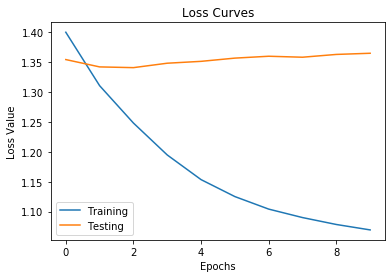

In [21]:
plt.plot(list(range(len(tloss))), tloss, label="Training")
plt.plot(list(range(len(vloss))), vloss, label = "Testing")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Loss Curves")

Text(0.5, 1.0, 'Accuracy Value')

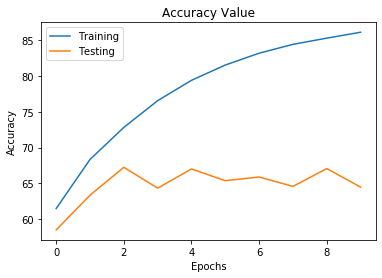

In [22]:
plt.plot(list(range(len(tacc))), tacc, label="Training")
plt.plot(list(range(len(vacc))), vacc, label = "Testing")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Value")

In [23]:
pos_sent = "This food was awesome!"

pos_rev = SENT_FIELD.process([SENT_FIELD.preprocess(pos_sent)])

net.eval()
pred = net(pos_rev.to(dev))

print("Review Rating as predicted : {}".format(pred.topk(1)[1].item() + 1))

Review Rating as predicted : 5


In [24]:
pos_sent = "I just hated that food. Not recommended at all."

pos_rev = SENT_FIELD.process([SENT_FIELD.preprocess(pos_sent)])

net.eval()
pred = net(pos_rev.to(dev))

print("Review Rating as predicted : {}".format(pred.topk(1)[1].item() + 1))

Review Rating as predicted : 1


In [25]:
vocab_dict = {}
for z in range(len(SENT_FIELD.vocab)):
    vocab_dict[SENT_FIELD.vocab.itos[z]] = z

import pickle

with open("./vocabdict.pkl", "wb") as f:
    pickle.dump([vocab_dict], f)